In [1]:
!pip install faiss-gpu pytorch-metric-learning
from fastai.vision.all import *
import logging
import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
DP = True if torch.cuda.device_count() > 1 else False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 7.6 MB/s eta 0:00:00


In [2]:
class CustomModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        embeddings = self.get_embedding(x)
        classifications = self.head(embeddings)
        return nn.Flatten()(embeddings), classifications

    def get_embedding(self, x):
        x = self.encoder(x)
        return x

backbone=efficientnet_v2_s(weights="DEFAULT")
encoder = create_body(backbone)
head = create_head(backbone.classifier[-1].in_features, 37, [1024, 512], 0.5, bn_final=True)
apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head)) if DP else CustomModel(encoder, head)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 89.9MB/s]


In [3]:
#model

In [4]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers,regularizers
from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from collections import defaultdict
import random

def get_image_files_sample(path):
    files = get_image_files(path)
    label_pattern = r'(.+)_\d+.jpg$'
    label_func = using_attr(RegexLabeller(label_pattern), 'name')
    label_to_files = defaultdict(list)
    for file in files:
        label = label_func(file)
        label_to_files[label].append(file)
    sampled_files = []
    for files in label_to_files.values():
        sampled_files.extend(random.sample(files, min(50, len(files))))
    return sampled_files

pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files_sample, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))
loaders = pets.dataloaders("/kaggle/input/the-oxfordiiit-pet-dataset/images")

In [5]:
#len(loaders.vocab)

In [6]:
#loaders.train.show_batch(max_n=6, nrows=2)

In [7]:
#loaders.valid.show_batch(max_n=6, nrows=2)

In [8]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.1, high=0.9)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
classification_loss = torch.nn.CrossEntropyLoss()

def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
        mined = miner(embeddings, labels)
        return loss_func(embeddings, labels, mined)
    return loss
  
my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, without_embed=False, without_ce=False):
        super().__init__()
        self.embed_loss_func = embed_loss_func
        self.class_loss_func = class_loss_func
        self.without_embed = without_embed
        self.without_ce = without_ce
    def forward(self, preds, target):
        embeddings, classifications = preds
        embed_loss = self.embed_loss_func(embeddings, target)
        class_loss = self.class_loss_func(classifications, target)
        if self.without_embed:
            return class_loss
        elif self.without_ce:
            return embed_loss
        else:
            return embed_loss + class_loss

combined_loss = CombinedLoss(my_loss, classification_loss,without_embed=True)

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback],
              metrics=[accuracy,precision,recall,f1score])

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,3.759597,2.917090,0.243243,0.395782,0.348479,0.186243,00:13
1,3.279018,1.931436,0.602703,0.653523,0.654103,0.504327,00:11
2,2.804037,1.278185,0.772973,0.794995,0.786173,0.688111,00:11
3,2.375600,0.955949,0.818919,0.818042,0.816251,0.728694,00:11
4,2.033898,0.796575,0.840541,0.851507,0.833955,0.770134,00:11
5,1.759139,0.699225,0.864865,0.887171,0.865813,0.803832,00:11
6,1.538076,0.634942,0.881081,0.887982,0.880535,0.819011,00:11
7,1.359699,0.608981,0.886486,0.895608,0.887495,0.825388,00:11
8,1.222186,0.565050,0.900000,0.904139,0.889479,0.836409,00:11
9,1.114218,0.533008,0.900000,0.902314,0.891130,0.833563,00:11


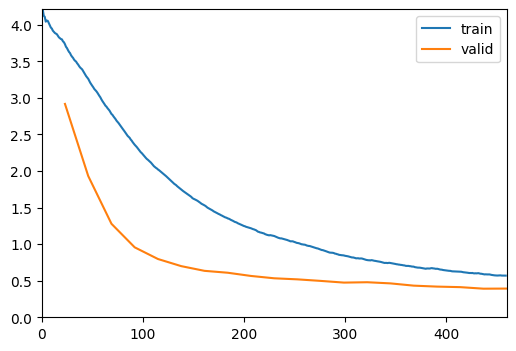

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,0.468169,0.386596,0.913514,0.919214,0.910620,0.861576,00:14
1,0.465499,0.390797,0.918919,0.920575,0.920675,0.878269,00:14
2,0.453145,0.379621,0.927027,0.925341,0.929233,0.888551,00:14
3,0.447890,0.375017,0.924324,0.920964,0.927768,0.883194,00:14
4,0.433638,0.367053,0.924324,0.927260,0.925896,0.888138,00:14
5,0.431128,0.381642,0.918919,0.919360,0.926478,0.883440,00:14
6,0.412704,0.364952,0.921622,0.911412,0.929603,0.876416,00:14
7,0.398415,0.358484,0.918919,0.910482,0.918782,0.868945,00:14
8,0.394684,0.362134,0.918919,0.918652,0.925850,0.880257,00:14
9,0.372281,0.350730,0.918919,0.913831,0.917286,0.865565,00:14


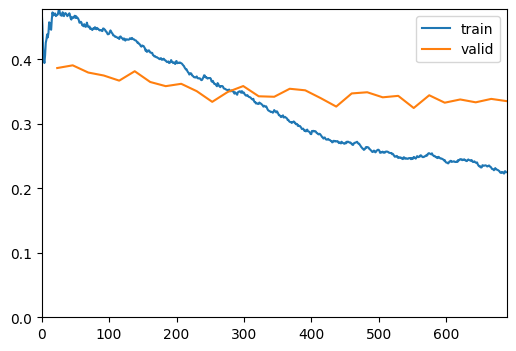

In [10]:
learn.fine_tune(30,freeze_epochs=20)

In [11]:
hooks = Hooks(model.module.encoder if DP else model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    hooks_output = nn.Flatten()(hooks.stored[-1])
    hooks_output = hooks_output.to(ftrs.device)  # move hooks_output to the same device as ftrs
    ftrs = torch.cat((ftrs, hooks_output))

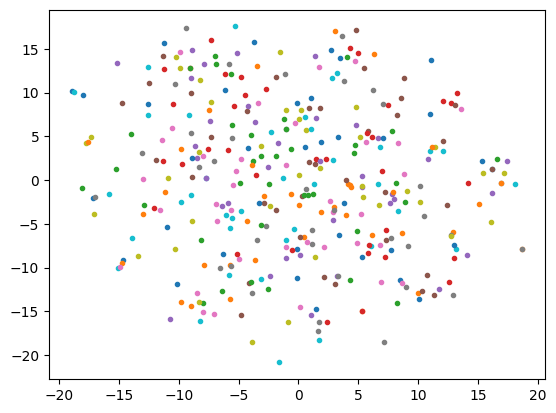

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

2024-05-02 07:09:24.297376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 07:09:24.297502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 07:09:24.430030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


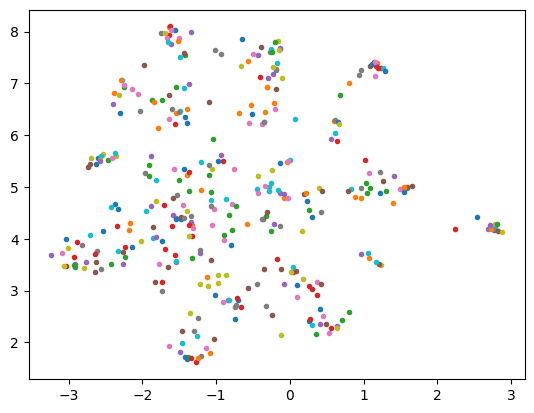

In [13]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')